In [3]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
import math

# Initialize result storage
results = []

# Function to calculate SNR
def calculate_SNR(signal_region):
    mean_signal = np.mean(signal_region)
    noise = np.std(signal_region)
    return mean_signal / noise if noise != 0 else 0

# Function to calculate contrast
def calculate_contrast(SI_CBD, SI_periductal):
    return (SI_CBD - SI_periductal) / (SI_CBD + SI_periductal)

# Function to calculate CNR
def calculate_CNR(SI_CBD, SI_periductal, noise_CBD, noise_periductal):
    if noise_CBD == 0 or noise_periductal == 0:
        return 0
    noise_rms = math.sqrt((noise_CBD**2 + noise_periductal**2) / 2)
    return (SI_CBD - SI_periductal) / noise_rms

# Function to calculate FWHM after projection onto the coronal plane
def calculate_FWHM_projection(region):
    """
    Function to calculate FWHM after projecting multi-dimensional data onto the coronal plane.
    Handles both 3D and 1D arrays.
    """
    # Ensure the region is 3D before projection
    if region.ndim == 3:
        # Step 1: Project the 3D data onto the coronal plane (e.g., by summing along the coronal axis)
        projection = np.mean(region, axis=1)  # Project along the coronal plane

        # Step 2: Reduce to a 1D signal
        profile_1d = np.sum(projection, axis=1)  # Summing along rows to get a 1D profile
    else:
        # If the region is already 1D (e.g., all values are non-zero), treat it as a 1D profile
        profile_1d = region

    # Step 3: Calculate FWHM on the 1D profile
    max_val = np.max(profile_1d)
    half_max_val = max_val / 2

    indices_above_half_max = np.where(profile_1d >= half_max_val)[0]

    # Calculate FWHM if points above half max are found
    if len(indices_above_half_max) > 0:
        lower_index = indices_above_half_max[0]
        upper_index = indices_above_half_max[-1]
        return upper_index - lower_index  # FWHM calculation

    return 0  # If no values above half max, FWHM is 0

# Function to process image and ground truth for multiple dilation radii
def process_file(file, img_dir, gt_dir, output_dir, dilation_radii):
    img_path = os.path.join(img_dir, file)
    gt_path = os.path.join(gt_dir, file)
    
    # Read image and ground truth
    img = sitk.ReadImage(img_path)
    GT = sitk.ReadImage(gt_path)

    for radius in dilation_radii:
        # Convert GT to binary and dilate with the given radius
        GT_cast = sitk.Cast(GT, sitk.sitkUInt8)
        GT_dilated = sitk.BinaryDilate(GT_cast, radius)

        # Convert to numpy arrays
        img_arr = sitk.GetArrayFromImage(img)
        GT_arr = sitk.GetArrayFromImage(GT_cast)
        GT_dilated_arr = sitk.GetArrayFromImage(GT_dilated)

        # Define CBD and periductal regions
        GT_region = img_arr * GT_arr
        GT_region_dilated = img_arr * GT_dilated_arr
        GT_periduct = GT_region_dilated - GT_region

        # Calculate metrics
        SI_CBD = np.mean(GT_region[GT_region > 0])
        SI_periductal = np.mean(GT_periduct[GT_periduct > 0])
        noise_CBD = np.std(GT_region[GT_region > 0])
        noise_periductal = np.std(GT_periduct[GT_periduct > 0])

        SNR_CBD = calculate_SNR(GT_region[GT_region > 0])
        contrast = calculate_contrast(SI_CBD, SI_periductal)
        CNR = calculate_CNR(SI_CBD, SI_periductal, noise_CBD, noise_periductal)
        FWHM_CBD = calculate_FWHM_projection(GT_region)  # Pass the 3D region directly

        # Store the results
        results.append({
            "File": file,
            "Radius": radius,  # Add the radius as a parameter
            "SNR": SNR_CBD,
            "Contrast": contrast,
            "CNR": CNR,
            "FWHM": FWHM_CBD
        })

        # Save .nii.gz files for GT_region and GT_periduct
        save_nifti(img, GT_region, output_dir, file, f"GT_region_radius_{radius}")
        save_nifti(img, GT_periduct, output_dir, file, f"GT_periduct_radius_{radius}")

# Function to save NIFTI files
def save_nifti(img, data, output_dir, file_name, suffix):
    img_out = sitk.GetImageFromArray(data)
    img_out.CopyInformation(img)
    sitk.WriteImage(img_out, os.path.join(output_dir, f"{file_name}_{suffix}.nii.gz"))

# Process all files in a directory with different dilation radii
def process_files(img_dir, gt_dir, output_dir, dilation_radii):
    os.makedirs(output_dir, exist_ok=True)
    
    for file in os.listdir(img_dir):
        if not file.startswith('.'):
            process_file(file, img_dir, gt_dir, output_dir, dilation_radii)
    
    # Save results to Excel
    df_results = pd.DataFrame(results)
    df_results.to_excel(os.path.join(output_dir, "MRCP_Results.xlsx"), index=False)

# Define paths for datasets and results
def run_batch(img_dir, gt_dir, output_dir, dilation_radii):
    process_files(img_dir, gt_dir, output_dir, dilation_radii)
    print("Results saved to Excel and .nii.gz files.")

# Example: Running batch processing for Radiopaedia and CPTAC datasets with two dilation radii
# run_batch("/Users/ziling/Desktop/MRCP/data/NII_img_Radiopaedia",
#            "/Users/ziling/Desktop/MRCP/data/NII_GT_Radiopaedia", 
#            "/Users/ziling/Desktop/MRCP/results/results_Radiopaedia", [[6,6,6], [12,12,12]])
# run_batch("/Users/ziling/Desktop/MRCP/data/NII_img_CPTAC", 
#           "/Users/ziling/Desktop/MRCP/data/NII_GT_CPTAC", 
#           "/Users/ziling/Desktop/MRCP/results/results_CPTAC", [[6,6,6], [12,12,12]])
run_batch("/Users/ziling/Desktop/MRCP/data/NII_img", 
          "/Users/ziling/Desktop/MRCP/data/NII_GT", 
          "/Users/ziling/Desktop/MRCP/results/results_LocData", [[6,6,6], [12,12,12]])

Results saved to Excel and .nii.gz files.


/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/pyvista/core/utilities/points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(
/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


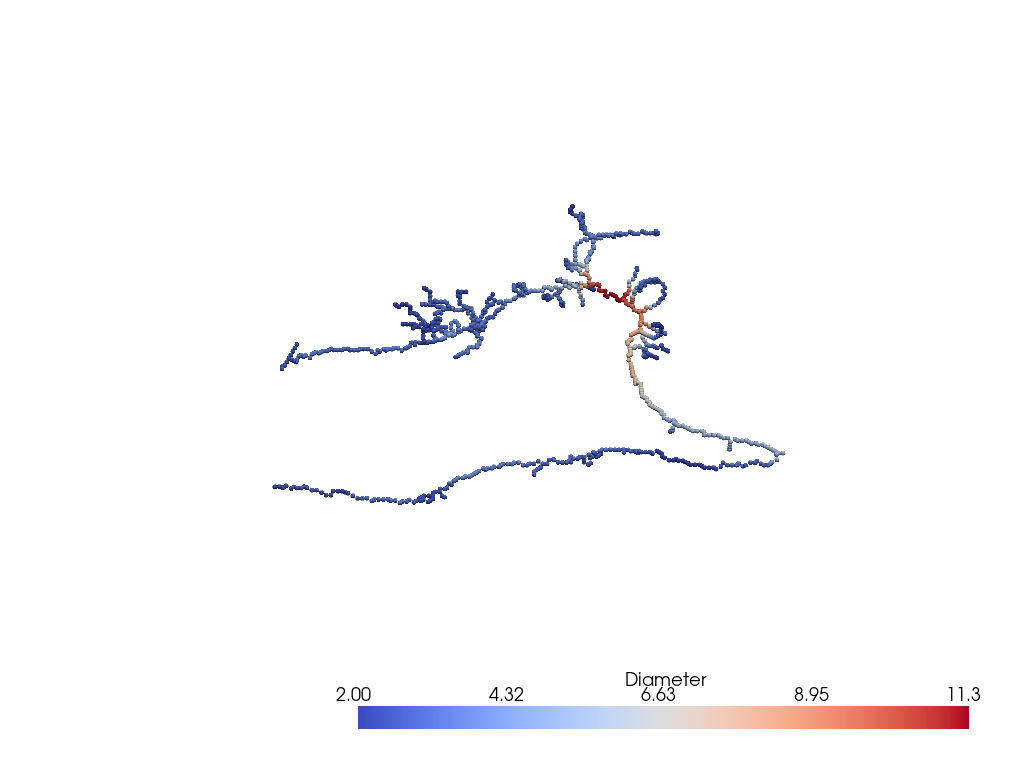

In [6]:
import numpy as np
import nibabel as nib
from scipy.ndimage import distance_transform_edt
import pyvista as pv
import skimage.morphology as morph
from scipy.spatial import KDTree

# Load and process data
nii_path = '/Users/ziling/Desktop/MRCP/data/NII_GT/MRCP0030003.nii.gz'  # Update with your file path
nii_img = nib.load(nii_path)
binary_image = nii_img.get_fdata().astype(bool)

# Skeletonization to find the centerline
skeleton = morph.skeletonize_3d(binary_image)
centerline_points = np.argwhere(skeleton)

# Calculate distance transform for diameter calculation
distances = distance_transform_edt(binary_image)

# Compute the KD-tree for quick neighbor search
tree = KDTree(centerline_points)
# Define search radius
radius = 5  # Adjust based on desired local averaging effect

# Calculate the average diameter in local neighborhood for each centerline point
average_diameters = []
for point in centerline_points:
    # Find all points within the specified radius
    neighbors = tree.query_ball_point(point, radius)
    # Compute local average diameter
    local_diameters = 2 * distances[centerline_points[neighbors][:, 0],
                                   centerline_points[neighbors][:, 1],
                                   centerline_points[neighbors][:, 2]]
    average_diameters.append(np.mean(local_diameters))

# Create the 3D rendering with PyVista
centerline_mesh = pv.PolyData(centerline_points)
centerline_mesh['Diameter'] = average_diameters

plotter = pv.Plotter()
plotter.add_mesh(centerline_mesh, scalars='Diameter', cmap='coolwarm', point_size=5, render_points_as_spheres=True)
plotter.set_background('white')
plotter.show()

/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/pyvista/core/utilities/points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(
/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


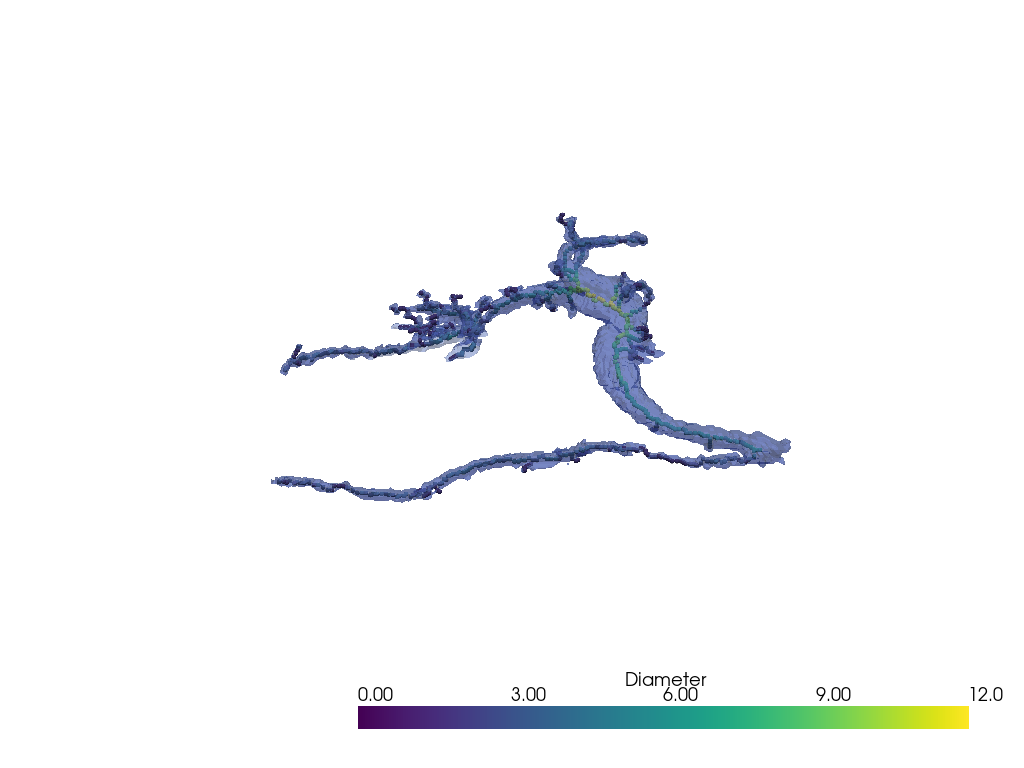

In [16]:
import numpy as np
import nibabel as nib
from scipy.ndimage import distance_transform_edt
import pyvista as pv
import skimage.morphology as morph

# Load the binary image
nii_path = '/Users/ziling/Desktop/MRCP/data/NII_GT/MRCP0030003.nii.gz'
nii_img = nib.load(nii_path)
binary_image = nii_img.get_fdata().astype(bool)

# Compute the distance transform
distances = distance_transform_edt(binary_image)

# Wrap the distance transform data as a PyVista volume
volume = pv.wrap(distances)

# Extract an isosurface at a certain threshold (e.g., 0.5)
surface = volume.contour(isosurfaces=[0.5])

# Retrieve the surface points' coordinates and calculate diameters
points = surface.points
diameters = 2 * distances[points[:, 0].astype(int), points[:, 1].astype(int), points[:, 2].astype(int)]
surface['Diameter'] = diameters

# Extract the skeleton to get the centerline
skeleton = morph.skeletonize_3d(binary_image)
centerline_points = np.argwhere(skeleton)
centerline_diameters = 2 * distances[centerline_points[:, 0], centerline_points[:, 1], centerline_points[:, 2]]

# Create a PyVista PolyData object for the centerline
centerline_mesh = pv.PolyData(centerline_points)
centerline_mesh['Diameter'] = centerline_diameters

# Render the 3D surface with the centerline overlay
plotter = pv.Plotter()
plotter.add_mesh(surface, scalars='Diameter', cmap='coolwarm', opacity=0.5, show_edges=False)
plotter.add_mesh(centerline_mesh, scalars='Diameter', cmap='viridis', point_size=5, render_points_as_spheres=True)
plotter.set_background('white')
plotter.show()

/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/pyvista/core/utilities/points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(
/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


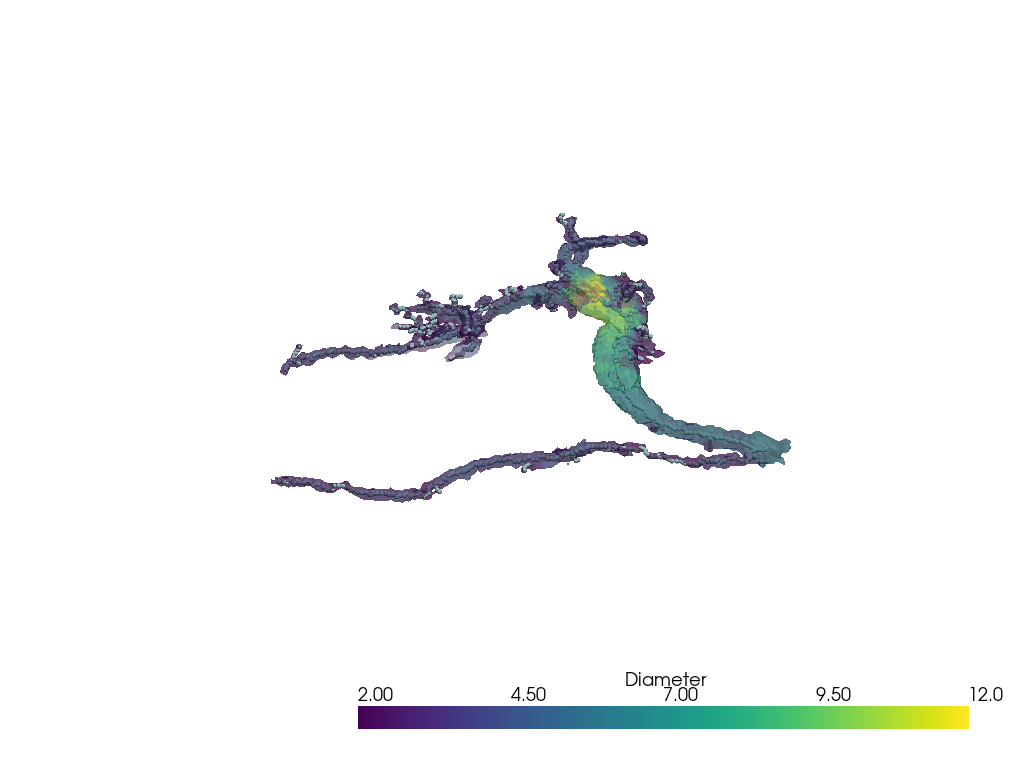

In [51]:
import numpy as np
import nibabel as nib
from scipy.ndimage import distance_transform_edt
import pyvista as pv
import skimage.morphology as morph
from scipy.spatial import cKDTree

# 加载并处理数据
nii_path = '/Users/ziling/Desktop/MRCP/data/NII_GT/MRCP0030003.nii.gz'
nii_img = nib.load(nii_path)
binary_image = nii_img.get_fdata().astype(bool)

# 计算距离变换并生成表面
distances = distance_transform_edt(binary_image)
volume = pv.wrap(distances)
surface = volume.contour(isosurfaces=[0.5])

# 骨架化以提取中心线
skeleton = morph.skeletonize_3d(binary_image)
centerline_points = np.argwhere(skeleton)
centerline_diameters = 2 * distances[tuple(centerline_points.T)]

# 创建KD树以高效查找最近的中心线点
tree = cKDTree(centerline_points)
surface_points = surface.points

# 查找表面每个点到最近的中心线点的距离索引
_, indices = tree.query(surface_points)
nearest_diameters = centerline_diameters[indices]

# 将直径信息映射到表面
surface['Diameter'] = nearest_diameters

# 渲染表面并根据直径着色，同时叠加中心线
plotter = pv.Plotter()
plotter.add_mesh(surface, scalars='Diameter', cmap='viridis', opacity=0.5, show_edges=False)
plotter.add_mesh(pv.PolyData(centerline_points), cmap='viridis', 
                 point_size=5, render_points_as_spheres=True)
plotter.set_background('white')
plotter.show()

/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/ziling/anaconda3/envs/radiomics_envs/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


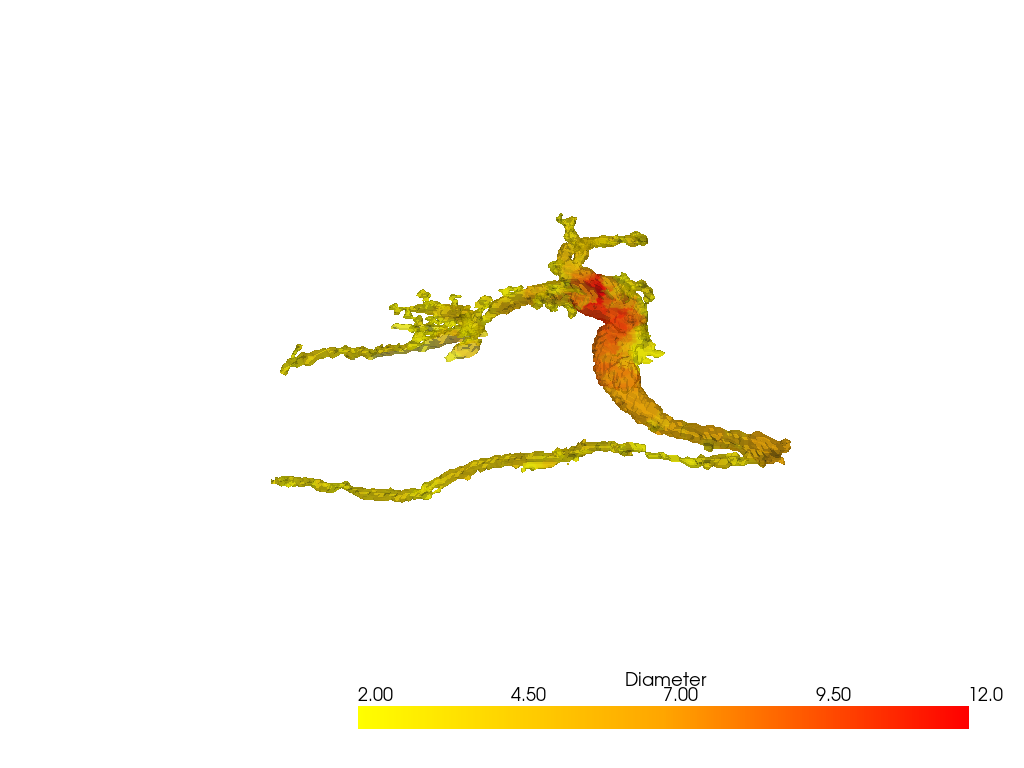

In [50]:
import numpy as np
import nibabel as nib
from scipy.ndimage import distance_transform_edt
import pyvista as pv
import skimage.morphology as morph
from scipy.spatial import cKDTree
from matplotlib.colors import LinearSegmentedColormap

# 加载并处理数据
nii_path = '/Users/ziling/Desktop/MRCP/data/NII_GT/MRCP0030003.nii.gz'
nii_img = nib.load(nii_path)
binary_image = nii_img.get_fdata().astype(bool)

# 计算距离变换并生成表面
distances = distance_transform_edt(binary_image)
volume = pv.wrap(distances)
surface = volume.contour(isosurfaces=[0.5])

# 骨架化以提取中心线
skeleton = morph.skeletonize_3d(binary_image)
centerline_points = np.argwhere(skeleton)
centerline_diameters = 2 * distances[tuple(centerline_points.T)]

# 创建KD树以高效查找最近的中心线点
tree = cKDTree(centerline_points)
surface_points = surface.points

# 查找表面每个点到最近的中心线点的距离索引
_, indices = tree.query(surface_points)
nearest_diameters = centerline_diameters[indices]

# 将直径信息映射到表面
surface['Diameter'] = nearest_diameters

# 自定义颜色映射（红-黄-蓝-绿）
# colors = [(1, 0, 0), (1, 1, 0), (0, 0, 1), (0, 1, 0)]  # 红-黄-蓝-绿
# cmap = LinearSegmentedColormap.from_list("BlueGreenYellowRed", colors)

# # 自定义颜色映射（蓝-绿-黄-红）
# colors = [(0, 0, 1),  (1, 1, 0), (1, 0, 0)]  # 蓝-绿-黄-红
# cmap = LinearSegmentedColormap.from_list("YellowOrangeRed", colors, N=256)
# 定义黄橙红的渐变颜色映射
colors = [(1, 1, 0), (1, 0.65, 0), (1, 0, 0)]  # 黄色、橙色、红色
cmap = LinearSegmentedColormap.from_list("YellowOrangeRed", colors, N=256)

# 渲染表面并根据直径着色
plotter = pv.Plotter()
plotter.add_mesh(surface, scalars='Diameter', cmap=cmap, opacity=0.8, show_edges=False)
plotter.set_background('white')
plotter.show()